# USA Drought Projection with Scikit-Learn

This project is developed as a course project for the **Introduction to Data Analytics in Business** taught in 2024 fall Semester.

The dataset used in the project is extracted from the *Google Earth Engine* using 5 different databases as a source. Python code for the dataset extraction can be found in the Github repository. 4 of the aforementioned databases are used to extract past climate data (from Jan, 2010 to Dec, 2023). The fifth database, *NASA/GDDP-CMIP6* is used to extract NASA's climate predictions from 2024 to 2050.

We have utilized a US Climate Regions geojson file provided by *data.gov* for data extraction. All extracted data were either monthly aggregated or aggregated by the our code.

Our aim is to predict the **Palmer Drought Severity Index**(PDSI), using more than 20 different features, either directly extracted from the Earth Engine or articulated by the code below. Some of the features available in the original dataset are dropped due to Nasa predictions not including them. 

Columns in the unaltered database are as follow:

- **PDSI** (target variable): Palmer Drought Severity Index (scale from -4 or less extreme drought to 4 or more extremely wet).
- **id** (not a feature): Unique id of the climate region.
- **region** (not a feature): Name of the climate region.
- **time** (not a feature): Time of the first observation.
- **key** (not a feature): Unique id made up of id_year_of_observation_month_of_observation. Used as an index.
- **pr**: Daily average precipitation amount in milimeters
- **tmmm**: Minimum temperature in Celsius
- **tmmx**: Maximum temperature in Celsius
- **tmean**: Average of tmmn and tmmx
- **rmin**: Minimum relative humidity(%)
- **rmax**: Maximum relative humidity(%)
- **vs** (not a feature): Wind-speed at 10m in m/s
- **soil** (not a feature): Soil moisture, derived using a one-dimensional soil water balance model in milimeters
- **NDVI** (not a feature): 16-day NDVI(Normalized Difference Vegetation Index) average

We've tested 5 different models with different parameters through Randomized Search Cross Validation. SVM(kernel=rbf) provided the best model for our project. Data for the years from 2011 to 2021 are treated as a training set, whereas data for the years 2022 and 2023 are selected as a test set.

As a last step, we have utilized Nasa climate predictions to predict PDSI in 2050.

For more detailed information please refer to the project presentation and/or report or contact the repository owner.

## Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, expon, loguniform, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import root_mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from scipy import stats
import time
import warnings
import os

# random state to be used through the rest of the notebook
rs = 99

climate_df = pd.read_csv("csv/climate_data_combined.csv", index_col="key", parse_dates=["time"])
climate_df.rename(columns = {"time": "date"}, inplace=True)
climate_df = climate_df.reindex(labels=["id", "region", "date", "pdsi", "pr", "tmmn", "tmean", "tmmx", "rmin", "rmean", "rmax", "soil", "vs", "NDVI"], axis=1)
climate_df.head()

,id,region,date,pdsi,pr,tmmn,tmean,tmmx,rmin,rmean,rmax,soil,vs,NDVI
key,,,,,,,,,,,,,,
100_2010_01,100,SOUTHWEST,2010-01-05 06:00:00,1.895134,0.230954,-11.538098,-5.874110,-0.210123,51.494027,72.529147,93.564266,9.038629,40.227054,0.008972
100_2010_02,100,SOUTHWEST,2010-02-04 06:00:00,1.989804,0.338533,-13.471613,-6.998771,-0.525930,56.858131,77.666638,98.475144,9.038629,35.731376,0.035587
100_2010_03,100,SOUTHWEST,2010-03-01 06:00:00,2.004806,0.765005,-2.571184,3.772681,10.116545,43.770616,64.770841,85.771067,11.353289,43.958253,0.160379
100_2010_04,100,SOUTHWEST,2010-04-05 06:00:00,1.953891,2.882619,1.494553,8.630773,15.766993,33.048443,58.653316,84.258189,8.955909,54.348845,0.334968
100_2010_05,100,SOUTHWEST,2010-05-05 06:00:00,2.328733,3.235048,5.600794,12.015434,18.430074,38.939681,62.520512,86.101344,8.023217,61.057910,0.463088


In [2]:
climate_df.tail()

,id,region,date,pdsi,pr,tmmn,tmean,tmmx,rmin,rmean,rmax,soil,vs,NDVI
key,,,,,,,,,,,,,,
9_2023_08,9,NE OLYMPIC SAN JUAN,2023-08-03 06:00:00,-2.071500,0.391532,12.393347,18.199194,24.005040,50.110484,71.072681,92.034879,41.176442,29.701923,0.692032
9_2023_09,9,NE OLYMPIC SAN JUAN,2023-09-02 06:00:00,-2.267889,0.981250,8.767083,14.201354,19.635625,53.960417,75.131771,96.303125,34.529327,29.350962,0.695826
9_2023_10,9,NE OLYMPIC SAN JUAN,2023-10-02 06:00:00,-2.091698,1.540927,5.911492,10.544456,15.177419,59.019556,77.835383,96.651210,54.527404,28.105769,0.705484
9_2023_11,9,NE OLYMPIC SAN JUAN,2023-11-01 06:00:00,-1.992429,1.993333,1.872083,6.014062,10.156041,60.547292,78.986146,97.425000,122.331250,30.009615,0.706766
9_2023_12,9,NE OLYMPIC SAN JUAN,2023-12-01 06:00:00,-2.393701,2.944355,3.174194,6.197379,9.220564,67.721573,81.302722,94.883871,191.694712,34.293269,0.627220


In [3]:
# add season category, and date columns for visualizations
season_map = {1:"Winter", 2:"Winter", 3:"Spring", 4:"Spring", 5:"Spring", 6:"Summer", 7:"Summer", 8:"Summer", 9:"Autumn", 10:"Autumn", 11:"Autumn", 12:"Winter"}
climate_df["season"] = climate_df["date"].dt.month.map(season_map)
climate_df["season"] = climate_df["season"].astype("category")
climate_df["year"] = climate_df["date"].dt.year
climate_df["month"] = climate_df["date"].dt.month

In [4]:
# no null columns
# no need for dtype optimization as the memory usage is low
climate_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59640 entries, 100_2010_01 to 9_2023_12
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      59640 non-null  int64         
 1   region  59640 non-null  object        
 2   date    59640 non-null  datetime64[ns]
 3   pdsi    59640 non-null  float64       
 4   pr      59640 non-null  float64       
 5   tmmn    59640 non-null  float64       
 6   tmean   59640 non-null  float64       
 7   tmmx    59640 non-null  float64       
 8   rmin    59640 non-null  float64       
 9   rmean   59640 non-null  float64       
 10  rmax    59640 non-null  float64       
 11  soil    59640 non-null  float64       
 12  vs      59640 non-null  float64       
 13  NDVI    59640 non-null  float64       
 14  season  59640 non-null  category      
 15  year    59640 non-null  int32         
 16  month   59640 non-null  int32         
dtypes: category(1), datetime64[ns](1), float6

In [5]:
# 355 unique id columns
climate_df["id"].value_counts()

id
100    168
359    168
334    168
333    168
332    168
      ... 
215    168
214    168
213    168
211    168
9      168
Name: count, Length: 355, dtype: int64

In [6]:
# not all region names are unique
climate_df["region"].value_counts()

region
NORTH CENTRAL          3696
SOUTH CENTRAL          3528
CENTRAL                3528
NORTHEAST              3024
SOUTHEAST              3024
                       ... 
CENTRAL MOUNTAIN        168
AR DRAINAGE BASIN       168
COASTAL AREA            168
EASTERN PIEDMONT        168
NE OLYMPIC SAN JUAN     168
Name: count, Length: 165, dtype: int64

In [7]:
# number of lines -> 355 regions * 12 months * 14 years(2010 to 2023) = 59640 
climate_df.shape

(59640, 17)

In [8]:
# looks like there are skewed features which will require further investigation
climate_df.describe(include=[np.number]).map('{:,.2f}'.format)

,id,pdsi,pr,tmmn,tmean,tmmx,rmin,rmean,rmax,soil,vs,NDVI,year,month
count,"59,640.00","59,640.00","59,640.00","59,640.00","59,640.00","59,640.00","59,640.00","59,640.00","59,640.00","59,640.00","59,640.00","59,640.00","59,640.00","59,640.00"
mean,188.68,0.23,2.72,5.81,12.04,18.26,41.85,63.53,85.21,68.85,34.68,0.48,"2,016.50",6.50
std,110.67,2.48,2.11,9.70,10.04,10.54,11.73,10.68,10.86,55.71,9.42,0.22,4.03,3.45
min,1.00,-8.15,0.00,-26.39,-20.60,-15.34,4.24,11.52,18.58,0.04,11.92,-0.04,"2,010.00",1.00
25%,92.00,-1.67,1.14,-1.45,4.40,10.23,35.39,59.07,81.56,18.73,27.61,0.30,"2,013.00",3.75
50%,184.00,0.19,2.35,6.08,12.83,19.50,43.23,65.54,87.56,62.57,33.76,0.48,"2,016.50",6.50
75%,285.00,2.01,3.77,13.59,20.32,27.01,49.80,70.81,92.29,104.45,41.01,0.67,"2,020.00",9.25
max,407.00,9.46,35.37,28.20,35.78,43.67,85.48,92.24,100.00,318.39,84.68,0.89,"2,023.00",12.00


In [9]:
# add previous 12,6,3 months averages for temperature, precipitation and humidity data

def add_rolling_averages(df, period_list=[3,6,12], feature_list = ["tmmn", "tmean", "tmmx", "pr", "rmin", "rmean", "rmax"]):

    df.sort_values(by=["id", "date"], inplace=True)

    for feature in feature_list:
        for period in period_list:
            new_feat_name = f"{feature}_prev{str(period).zfill(2)}"
            df[new_feat_name] = df[feature].shift(1).rolling(window=period, step=1).mean()

add_rolling_averages(climate_df)

In [10]:
# add temp_diff feature
climate_df["temp_diff"] = climate_df["tmmx"] - climate_df["tmmn"]

## Descriptive Analysis and Visualizations

#### Seborn settings

In [11]:
sns.set(
    rc={
        "axes.facecolor": "#1E1E1E", "figure.facecolor": "#1E1E1E", "legend.facecolor": "#1E1E1E",
        "axes.labelcolor": "white", "legend.edgecolor": "None", "legend.labelcolor": "white",
        "xtick.color": "white", "ytick.color": "white", "text.color": "white",
        "axes.grid": False 
    }
)

### Histograms of Some Numeric Columns

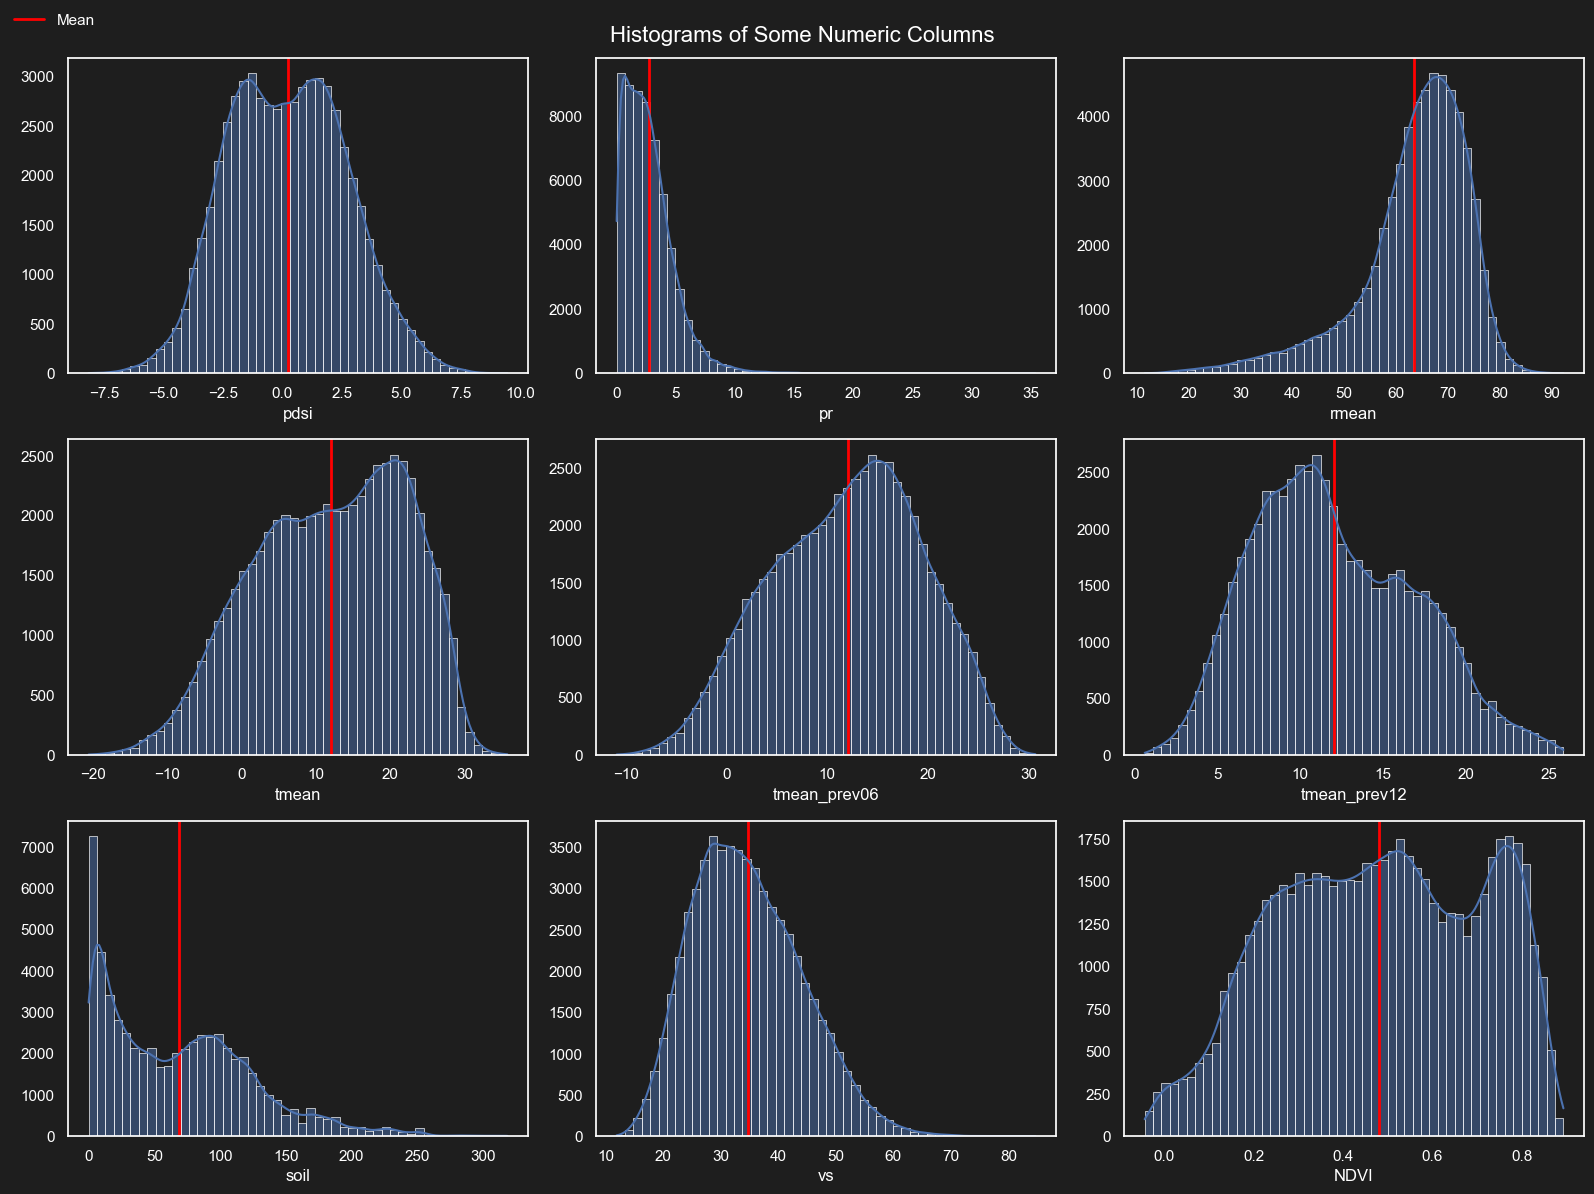

In [12]:
# Start with plotting histograms of some numeric columns
# Skewness of some features is obvious

numeric_columns = ["pdsi", "pr", "rmean", "tmean", "tmean_prev06", "tmean_prev12", "soil", "vs" , "NDVI"]

# Calculate number of rows needed for subplots
n_rows = (len(numeric_columns) - 1) // 3 + 1

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(16, 4 * n_rows))
fig.suptitle('Histograms of Some Numeric Columns', fontsize=16)

axes = axes.flatten()

# Plot histograms and line for mean
for i, col in enumerate(numeric_columns):    
    mean = climate_df[col].mean()
    axes[i].axvline(mean, color='red', linewidth=2, label='Median')   
    sns.histplot(data=climate_df, x=col, kde=True, ax=axes[i], bins=50)
    axes[i].set_ylabel('')    

# Remove extra subplots
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

# Add a legend for the figure
fig.legend(['Mean'], loc='upper left')

plt.tight_layout()
plt.show()

### Correlation Matrix

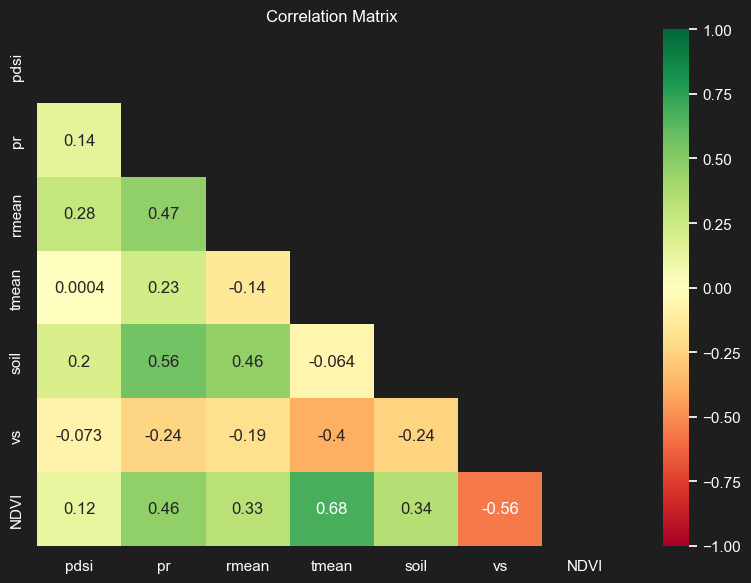

In [13]:
climate_corr = climate_df.loc[:,["pdsi", "pr", "rmean", "tmean", "soil", "vs", "NDVI"]].corr().round(4)
matrix = np.triu(climate_corr)

plt.figure(figsize=(8, 6))

corr_graph = sns.heatmap(
    climate_corr, 
    cmap="RdYlGn", 
    annot=True,
    vmin = -1,
    vmax = 1,
    mask=matrix
)

# Set white text for the axis labels and title
corr_graph.set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

### NDVI vs pr and tmean Relationships

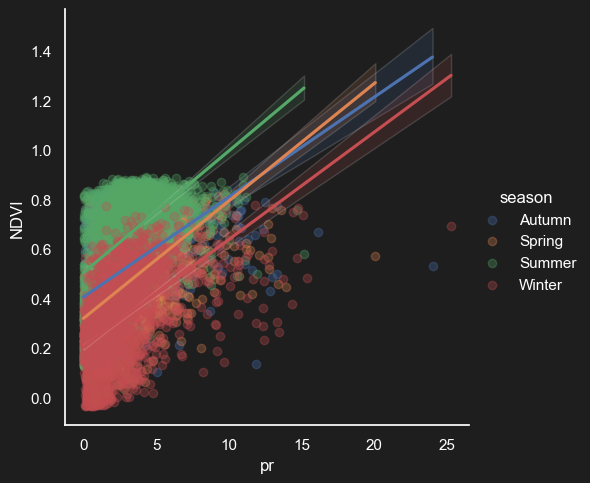

In [14]:
sns.lmplot(x="pr", y="NDVI", data=climate_df.sample(10000), hue="season", scatter_kws={"alpha": 0.3})
plt.show();

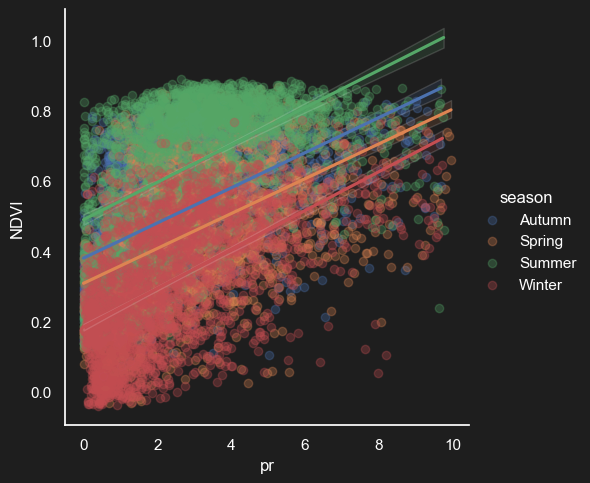

In [15]:
sns.lmplot(x="pr", y="NDVI", data=climate_df.query("pr < 10").sample(10000), hue="season", scatter_kws={"alpha": 0.3})
plt.show();

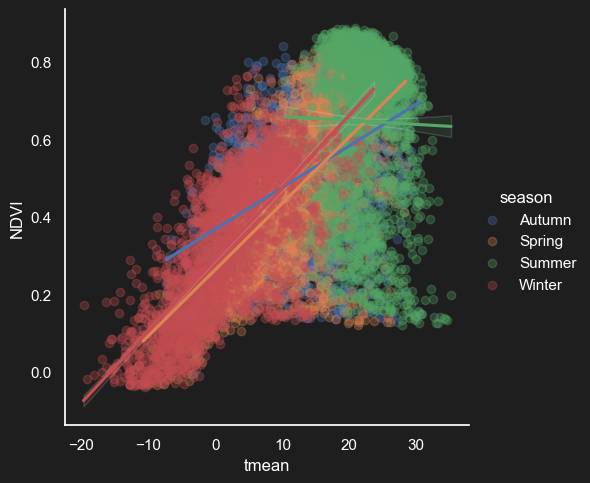

In [16]:
sns.lmplot(x="tmean", y="NDVI", data=climate_df.sample(10000), hue="season", scatter_kws={"alpha": 0.3})
plt.show();

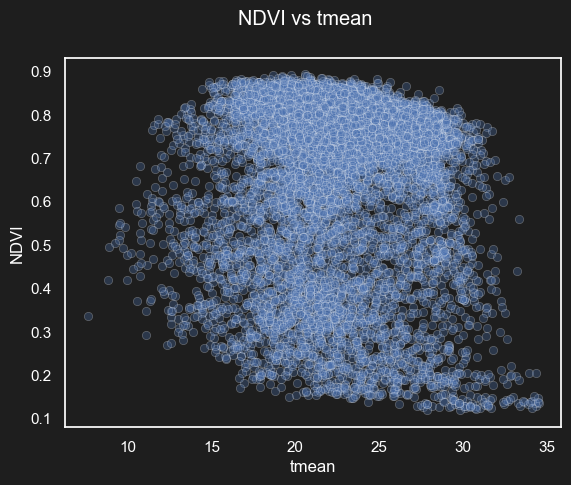

In [17]:
# for all seasons except summer data showed linearity
# investigate the relationship w/o season split

sns.scatterplot(x="tmean", y="NDVI", data=climate_df.query("season == 'Summer'").sample(10000), alpha=0.3)
plt.suptitle("NDVI vs tmean")
plt.show();

### PDSI over the Years

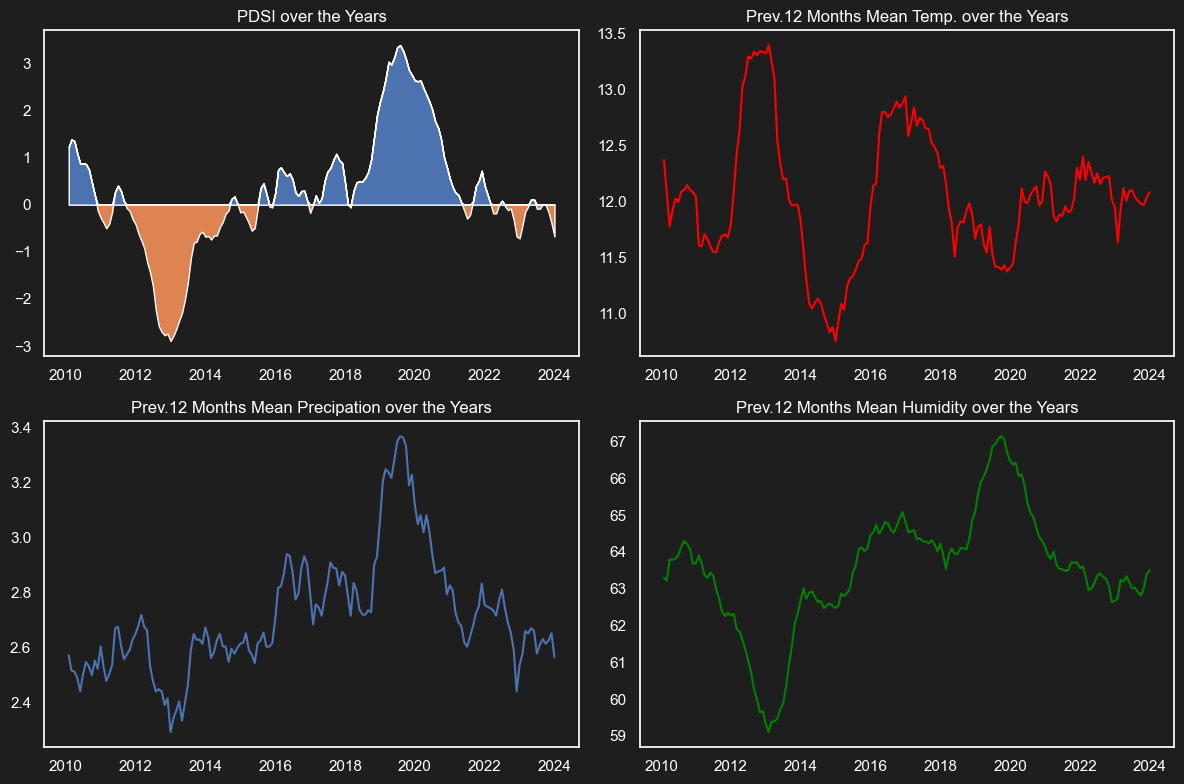

In [18]:
def pdsi_temp_pr_hm_chart(df):
    
    fig, ax = plt.subplots(2, 2, figsize=(12,8))

    chart_df = df.set_index("date")[["pdsi"]].resample("ME").mean()
    
    ax[0][0].stackplot(
        chart_df.index,
        chart_df.loc[:,["pdsi"]].apply(lambda row: max(row["pdsi"], 0), axis="columns"),
        chart_df.loc[:,["pdsi"]].apply(lambda row: min(row["pdsi"], 0), axis="columns"),
    )
    
    ax[0][0].set_title("PDSI over the Years")
    
    chart_df = df.set_index("date")[["tmean_prev12"]].resample("ME").mean()
    
    ax[0][1].plot(
        chart_df.index,
        chart_df["tmean_prev12"],
        color="red"
    )
    
    ax[0][1].set_title("Prev.12 Months Mean Temp. over the Years")
    
    chart_df = df.set_index("date")[["pr_prev12"]].resample("ME").mean()
    
    ax[1][0].plot(
        chart_df.index,
        chart_df["pr_prev12"]
    )
    
    ax[1][0].set_title("Prev.12 Months Mean Precipation over the Years")
    
    chart_df = df.set_index("date")[["rmean_prev12"]].resample("ME").mean()
    
    ax[1][1].plot(
        chart_df.index,
        chart_df["rmean_prev12"],
        color="green"
    )
    
    ax[1][1].set_title("Prev.12 Months Mean Humidity over the Years")
    
    plt.tight_layout()
    plt.show();

pdsi_temp_pr_hm_chart(climate_df)

In [19]:
def feature_diff(feat_name, ascd = True):

    df_2010 = climate_df.loc[:,[feat_name,"id","year"]].groupby(["id","year"]).agg("mean").reset_index().query("year == 2010")
    df_2023 = climate_df.loc[:,[feat_name,"id","year"]].groupby(["id","year"]).agg("mean").reset_index().query("year == 2023")
    df_diff = pd.merge(df_2010.loc[:,["id",feat_name]], df_2023.loc[:,["id",feat_name]], on="id", how="inner", suffixes=("_2010", "_2023"))
    df_diff["diff"] = df_diff[f"{feat_name}_2023"] - df_diff[f"{feat_name}_2010"]

    return df_diff.sort_values(by=("diff"), ascending=ascd).head(3)

In [20]:
# top 3 pdsi deterioration

feature_diff("pdsi", True)

,id,pdsi_2010,pdsi_2023,diff
161,168,6.033389,-2.701815,-8.735204
164,171,5.759468,-2.471641,-8.231108
144,151,4.867695,-2.661143,-7.528837


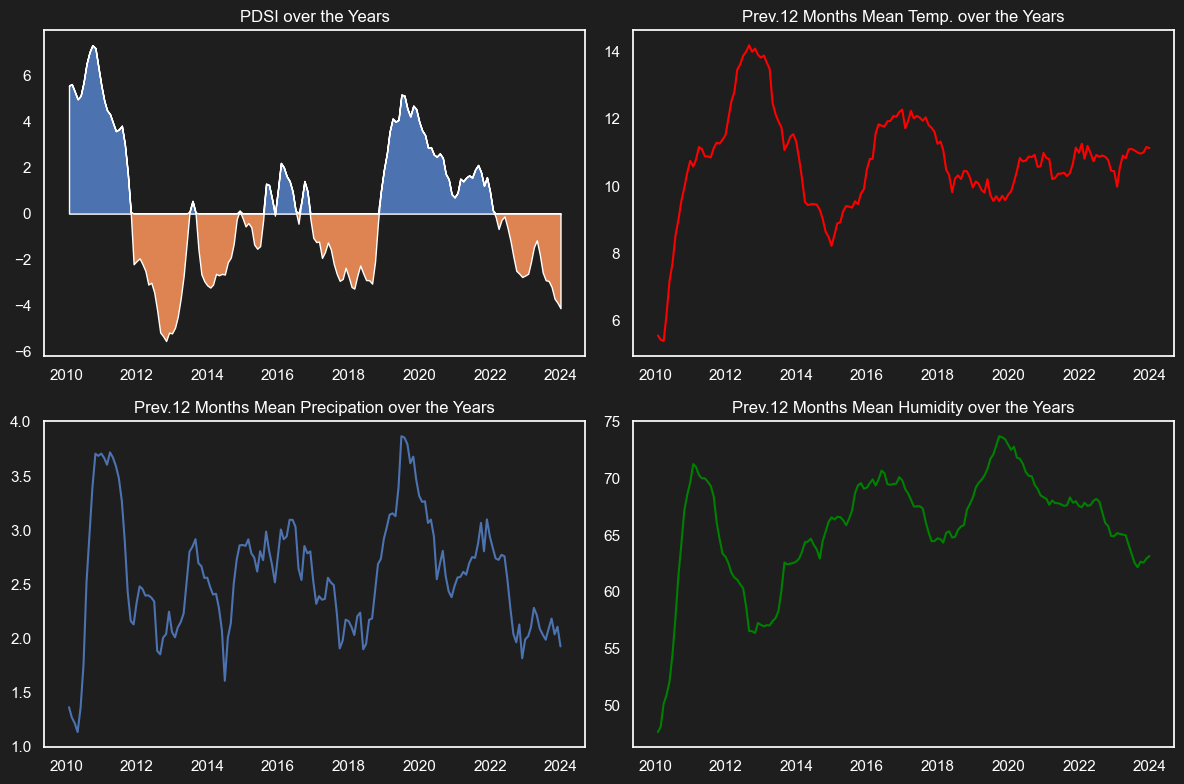

In [21]:
pdsi_temp_pr_hm_chart(climate_df.query("id == 168"))

In [22]:
# top 3 pdsi improvement

feature_diff("pdsi", False)

,id,pdsi_2010,pdsi_2023,diff
36,38,-3.005191,2.148119,5.153310
71,74,-2.068823,2.715922,4.784746
75,79,-1.401543,2.888679,4.290223


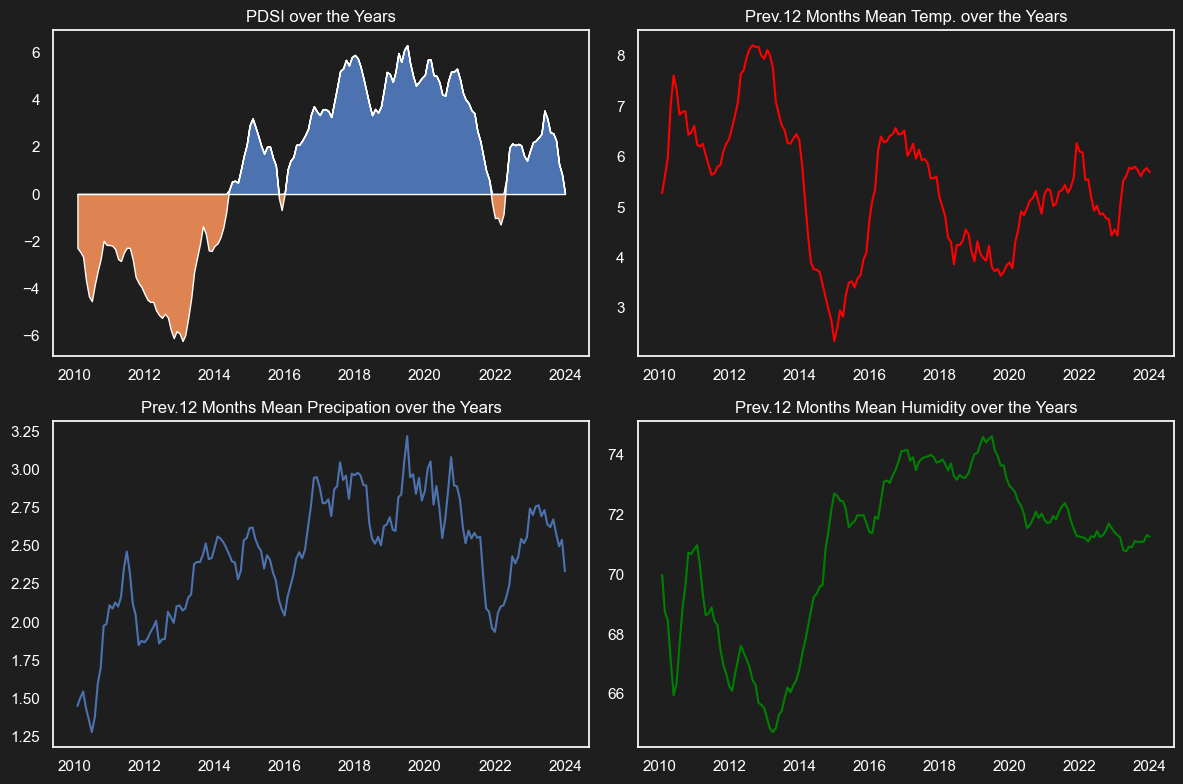

In [23]:
pdsi_temp_pr_hm_chart(climate_df.query("id == 38"))

## Data Preparation

### Removing non-feature Columns

In [24]:
climate_df.columns

Index(['id', 'region', 'date', 'pdsi', 'pr', 'tmmn', 'tmean', 'tmmx', 'rmin',
       'rmean', 'rmax', 'soil', 'vs', 'NDVI', 'season', 'year', 'month',
       'tmmn_prev03', 'tmmn_prev06', 'tmmn_prev12', 'tmean_prev03',
       'tmean_prev06', 'tmean_prev12', 'tmmx_prev03', 'tmmx_prev06',
       'tmmx_prev12', 'pr_prev03', 'pr_prev06', 'pr_prev12', 'rmin_prev03',
       'rmin_prev06', 'rmin_prev12', 'rmean_prev03', 'rmean_prev06',
       'rmean_prev12', 'rmax_prev03', 'rmax_prev06', 'rmax_prev12',
       'temp_diff'],
      dtype='object')

In [25]:
# Start by removing year 2010 as they lack data for features such as 'tmean_prev_12' 
# Then remove unnecessary columns
# Drop monthly values for which we calculated rolling 3,6 and 12 months averages
# Drop soil and NDVI columns as well since they are present in NASA climate predictions

y_all = climate_df.query("year != 2010").loc[:,["pdsi"]]
X_all = climate_df.query("year != 2010").drop(
            columns = ['id', 'region', 'date', 'pdsi', 'pr', 'tmmn', 'tmean', 'tmmx', 'rmin',
           'rmean', 'rmax', 'soil', 'NDVI', 'season', 'year', 'month']
)

### Analyze Skewness and Data Transformation

In [26]:
# Earlier, we found that some features were skewed. Investigate skewness further.

skewness = X_all.skew(axis=0, skipna=True, numeric_only=True)

right_mild_skew = skewness[(skewness.values >= 0.5) & (skewness.values < 1.0)]
right_heavy_skew = skewness[(skewness.values > 1.0)]
left_mild_skew = skewness[(skewness.values <= -0.5) & (skewness.values > -1.0)]
left_heavy_skew = skewness[(skewness.values < -1.0)]

print("right_mild_skew", right_mild_skew, sep="\n", end="\n\n")
print("right_heavy_skew", right_heavy_skew, sep="\n",end="\n\n")
print("left_mild_skew", left_mild_skew, sep="\n", end="\n\n")
print("left_heavy_skew", left_heavy_skew, sep="\n", end="\n\n")

right_mild_skew
pr_prev06    0.905118
dtype: float64

right_heavy_skew
pr_prev03    1.251982
dtype: float64

left_mild_skew
rmin_prev03   -0.623791
rmin_prev06   -0.794165
rmin_prev12   -0.897862
dtype: float64

left_heavy_skew
rmean_prev03   -1.390216
rmean_prev06   -1.488657
rmean_prev12   -1.578564
rmax_prev03    -2.018488
rmax_prev06    -2.085933
rmax_prev12    -2.196320
dtype: float64



In [27]:
# Apply sqrt transformation for features starts with 'pr' and 
# reflect* and log transformation to features starts with 'r'
# *reflect means taking the largest observation, max_inst, then subtracting each observation from max_inst + 1 

right_skew = ["pr_prev03", "pr_prev06", "pr_prev12"]
left_skew = [feat for feat in X_all.columns if feat.startswith("rm")]


for feat in X_all.columns:
    if feat in right_skew:
        X_all[feat] = np.sqrt(X_all[feat])
    elif feat in left_skew:
        max_inst = X_all[feat].max()
        X_all[feat] = max_inst + 1 - X_all[feat]
        X_all[feat] = np.log(X_all[feat])

In [28]:
# Rerun the skewness study to confirm transformation worked
# Almost all skewness is gone

skewness = X_all.skew(axis=0, skipna=True, numeric_only=True)

right_mild_skew = skewness[(skewness.values >= 0.5) & (skewness.values < 1.0)]
right_heavy_skew = skewness[(skewness.values > 1.0)]
left_mild_skew = skewness[(skewness.values <= -0.5) & (skewness.values > -1.0)]
left_heavy_skew = skewness[(skewness.values < -1.0)]

print("right_mild_skew", right_mild_skew, sep="\n", end="\n\n")
print("right_heavy_skew", right_heavy_skew, sep="\n",end="\n\n")
print("left_mild_skew", left_mild_skew, sep="\n", end="\n\n")
print("left_heavy_skew", left_heavy_skew, sep="\n", end="\n\n")

right_mild_skew
Series([], dtype: float64)

right_heavy_skew
Series([], dtype: float64)

left_mild_skew
rmin_prev03   -0.541888
dtype: float64

left_heavy_skew
Series([], dtype: float64)



### Removing Outliers

In [29]:
X_all.shape

(55380, 23)

In [30]:
# Removing outliers

isolation_forest = IsolationForest(random_state=rs)
outlier_pred = isolation_forest.fit_predict(X_all)

# number of outliers						  
np.count_nonzero(outlier_pred == -1)	

9273

In [31]:
X_all = X_all.iloc[outlier_pred == 1]
y_all = y_all.iloc[outlier_pred == 1]

## Model Selection and Tuning

### Train Test Split

In [32]:
# Train / Test split

years = []

for id in X_all.index:
    start_ind = id.find("_")+1
    year = id[start_ind:start_ind+4]
    years.append(year)

years = np.array([1 if int(year) < 2022 else 0 for year in years])


X_train = X_all[years == 1] # Select rows where years is 1 (train)
X_test = X_all[years == 0] # Select rows where years is 0 (test)
y_train = y_all[years == 1] # Select rows where years is 1 (train)
y_test = y_all[years == 0] # Select rows where years is 0 (test)

y_all = np.array(y_all["pdsi"]) # Convert to 1d array
y_train = np.array(y_train["pdsi"]) # Convert to 1d array
y_test = np.array(y_test["pdsi"]) # Convert to 1d array

test_pct = len(X_test) / len(X_all)
test_pct 

0.15470535927299542

### Randomized Search Cross Validation

In [33]:
# Create a dictionary of selected models

max_num_feat = len(X_train.columns)

dict_regressors = {
    
    "Linear Regression": {
        "initiator": LinearRegression(),
        "parameters": {}
    },

    "k-Nearest_Neighbors": {
        "initiator": KNeighborsRegressor(),
        "parameters": {
            "k-Nearest_Neighbors__n_neighbors": list(range(1, 50)),
            "k-Nearest_Neighbors__weights": ["uniform", "distance"],                                         
        }
    },
    
    "Random_Forest": {
        "initiator": RandomForestRegressor(random_state=rs),
        "parameters": {
            "Random_Forest__n_estimators": randint(low=5, high=100),
            "Random_Forest__max_features": randint(low=2, high=max_num_feat),
            "Random_Forest__max_depth": [None] + list(randint(low=10, high=100).rvs(size=20))
        }
    },

    "SVM": {
        "initiator": SVR(),
        "parameters": {
            "SVM__kernel": ["rbf"],
            "SVM__C": [0.1, 1, 10],
            "SVM__gamma": [0.001, 1, "scale"]
        }
    },

    "Gradient_Boosting_Regressor": {
        "initiator": GradientBoostingRegressor(random_state=rs),
        "parameters": {
            "Gradient_Boosting_Regressor__n_estimators": randint(low=5, high=100),
            "Gradient_Boosting_Regressor__max_features": randint(low=2, high=max_num_feat),
            "Gradient_Boosting_Regressor__max_depth": [None] + list(randint(low=10, high=100).rvs(size=20))
        }
    },

    "Neural_Network": {
        "initiator": MLPRegressor(random_state=rs, max_iter=1000),
        "parameters": {
            "Neural_Network__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 100)],
            "Neural_Network__activation": ["tanh", "relu", "logistic", "identity"],
            "Neural_Network__solver": ["sgd", "adam", "lbfgs"],
            "Neural_Network__alpha": uniform(0.0001, 0.5),
            "Neural_Network__learning_rate": ["constant", "adaptive", "invscaling"],
        }
    },    
}

In [34]:
# WARNING: Below line might take couple hours to run

# Create a pipeline which will standardize first and then apply the model
# Run Randomized Search to find the best model and parameters

# to avoid running linear regression without a parameter dictionary
warnings.filterwarnings('ignore', category=UserWarning)

model_list = dict_regressors.keys()
model_score = []
model_score_std = []
best_params = []
process_time = []

for regressor_name, regressor in dict_regressors.items():
    model_pipeline = Pipeline([
        ("standarscaler", StandardScaler()),
        (regressor_name, regressor["initiator"])
    ])

    print(f"Training {regressor_name}...")

    rnd_search = RandomizedSearchCV(
        model_pipeline, param_distributions=regressor["parameters"], cv=3, n_iter=10,
        scoring="neg_root_mean_squared_error"
    )
    start_t = time.time()
    rnd_search.fit(X_train, y_train)
    end_t = time.time()

    process_time.append((end_t-start_t))

    cs_results = rnd_search.cv_results_

    best_params.append(rnd_search.best_params_)

    # Get mean and standard deviation of test scores (neg RMSE)
    mean_rmse = cs_results['mean_test_score'][rnd_search.best_index_] * -1  # Negate to get RMSE
    std_rmse = cs_results['std_test_score'][rnd_search.best_index_]

    model_score.append(mean_rmse)
    model_score_std.append(std_rmse)

    print(f"{regressor_name} Results: {mean_rmse:.2f} RMSE with a standard deviation of {std_rmse:.2f}")
    print(f"{regressor_name} Processing Time: {(end_t-start_t):.4f}")

Training Linear Regression...
Linear Regression Results: 2.27 RMSE with a standard deviation of 0.14
Linear Regression Processing Time: 0.1263
Training k-Nearest_Neighbors...
k-Nearest_Neighbors Results: 1.95 RMSE with a standard deviation of 0.25
k-Nearest_Neighbors Processing Time: 6.3002
Training Random_Forest...
Random_Forest Results: 1.97 RMSE with a standard deviation of 0.18
Random_Forest Processing Time: 259.1351
Training SVM...
SVM Results: 1.82 RMSE with a standard deviation of 0.35
SVM Processing Time: 1147.7655
Training Gradient_Boosting_Regressor...
Gradient_Boosting_Regressor Results: 1.98 RMSE with a standard deviation of 0.18
Gradient_Boosting_Regressor Processing Time: 578.6556
Training Neural_Network...
Neural_Network Results: 1.88 RMSE with a standard deviation of 0.25
Neural_Network Processing Time: 1740.3526


In [35]:
model_comparison = pd.DataFrame(
    {
        "Model": model_list,
        "Average RMSE": model_score,
        "Standard Deviation": model_score_std,
        "Processing Time": process_time,
        "Best Params.": best_params
    }
)

# below line of code only intended to save the randomized search result to avoid re-running it again.
model_comparison.to_csv('./csv/model_comparison.csv')
X_all.to_csv('./csv/X_all.csv')
X_test.to_csv('./csv/X_test.csv')
X_train.to_csv('./csv/X_train.csv')
pd.DataFrame(y_all).to_csv('./csv/y_all.csv')
pd.DataFrame(y_test).to_csv('./csv/y_test.csv')
pd.DataFrame(y_train).to_csv('./csv/y_train.csv')

In [36]:
model_comparison = model_comparison.sort_values(by="Average RMSE")
pd.set_option('display.max_colwidth', None)
model_comparison

,Model,Average RMSE,Standard Deviation,Processing Time,Best Params.
3,SVM,1.818576,0.347397,1147.765529,"{'SVM__kernel': 'rbf', 'SVM__gamma': 'scale', 'SVM__C': 10}"
5,Neural_Network,1.879422,0.250858,1740.352568,"{'Neural_Network__activation': 'logistic', 'Neural_Network__alpha': 0.19309955908175191, 'Neural_Network__hidden_layer_sizes': (50, 50), 'Neural_Network__learning_rate': 'invscaling', 'Neural_Network__solver': 'adam'}"
1,k-Nearest_Neighbors,1.951192,0.252958,6.300204,"{'k-Nearest_Neighbors__weights': 'distance', 'k-Nearest_Neighbors__n_neighbors': 18}"
2,Random_Forest,1.965550,0.176438,259.135123,"{'Random_Forest__max_depth': 72, 'Random_Forest__max_features': 2, 'Random_Forest__n_estimators': 34}"
4,Gradient_Boosting_Regressor,1.978033,0.177048,578.655563,"{'Gradient_Boosting_Regressor__max_depth': 51, 'Gradient_Boosting_Regressor__max_features': 2, 'Gradient_Boosting_Regressor__n_estimators': 44}"
0,Linear Regression,2.270204,0.137548,0.126303,{}


### Model Improvement

In [37]:
# Calcute the range of y to better judge model performance

y_range = y_all.max() - y_all.min()
y_range

17.09534646583768

In [38]:
# Looks like SVM performs much better on the whole training set

rbf_svm = Pipeline([
        ("standarscaler", StandardScaler()),
        ("SVM_rbf", SVR(kernel="rbf", gamma="scale", C=10))
    ])

rbf_svm.fit(X_train, y_train)
y_predict = rbf_svm.predict(X_train)

root_mean_squared_error(y_train, y_predict)

1.1298095476789394

In [39]:
# The best performing SVM was with C parameter equal to 10 which was the limit. Let's try with a higher C parameter

rbf_svm = Pipeline([
    ("standarscaler", StandardScaler()),
    ("SVM_rbf", SVR(kernel="rbf", gamma="scale", C=20))
])

rbf_svm.fit(X_train, y_train)
y_predict = rbf_svm.predict(X_train)

root_mean_squared_error(y_train, y_predict)

1.0586913629201582

In [40]:
# Looks like C=20 gives a better result
# It's time to test with the test set

rbf_svm = Pipeline([
        ("standarscaler", StandardScaler()),
        ("SVM_rbf", SVR(kernel="rbf", gamma="scale", C=20))
    ])

rbf_svm.fit(X_test, y_test)
y_predict = rbf_svm.predict(X_test)

root_mean_squared_error(y_test, y_predict)

0.7105182660558703

In [41]:
# WARNING: Below line might take couple hours to run

# Results are not satisfactory at this stage. Look for alternatives
# get feature importances

perm_importance = permutation_importance(rbf_svm, X_all, y_all, n_repeats=3, random_state=rs)
for i in range(X_all.shape[1]):
    print(f"Feature {i+1} ({X_all.columns[i]}): {perm_importance.importances_mean[i]:.4f}")

Feature 1 (vs): 0.0895
Feature 2 (tmmn_prev03): 0.1475
Feature 3 (tmmn_prev06): 0.1454
Feature 4 (tmmn_prev12): 0.8482
Feature 5 (tmean_prev03): 0.0560
Feature 6 (tmean_prev06): 0.1063
Feature 7 (tmean_prev12): 0.0618
Feature 8 (tmmx_prev03): 0.2250
Feature 9 (tmmx_prev06): 0.3962
Feature 10 (tmmx_prev12): 1.5809
Feature 11 (pr_prev03): 0.1629
Feature 12 (pr_prev06): 0.4941
Feature 13 (pr_prev12): 0.9984
Feature 14 (rmin_prev03): 0.1445
Feature 15 (rmin_prev06): 0.3037
Feature 16 (rmin_prev12): 0.2390
Feature 17 (rmean_prev03): 0.0432
Feature 18 (rmean_prev06): 0.0390
Feature 19 (rmean_prev12): 0.0383
Feature 20 (rmax_prev03): 0.1584
Feature 21 (rmax_prev06): 0.3034
Feature 22 (rmax_prev12): 0.0891
Feature 23 (temp_diff): 0.0849


In [42]:
# temp_diff, tmean and rmean given low importance
# try with removing these features
# the result is only very slightly worse 

X_less_features_train = X_train.drop(
    columns = ["tmean_prev03", "tmean_prev06", "tmean_prev12", "rmean_prev03", "rmean_prev06", "rmean_prev12", "temp_diff"]
)

rbf_svm = Pipeline([
        ("standarscaler", StandardScaler()),
        ("SVM_rbf", SVR(kernel="rbf", gamma="scale", C=20))
    ])

rbf_svm.fit(X_less_features_train, y_train)
y_predict = rbf_svm.predict(X_less_features_train)

root_mean_squared_error(y_train, y_predict)

1.076982351767423

In [43]:
# from the feature importance matrix, we see that prev 12 months have lots of importance for tmmn, tmmx, pr features
# try with adding previous 18 and 24 months and removing previous 3 months

climate_df = pd.read_csv("csv/climate_data_combined.csv", index_col="key", parse_dates=["time"])
climate_df.rename(columns = {"time": "date"}, inplace=True)
climate_df = climate_df.reindex(labels=["id", "region", "date", "pdsi", "pr", "tmmn", "tmmx", "rmin", "rmax", "vs"], axis=1)
climate_df["year"] = climate_df["date"].dt.year

add_rolling_averages(climate_df, period_list=[6,12,18,24] , feature_list=["tmmn", "tmmx", "pr", "rmin", "rmax"])

# the first two years of our data is now dropped
y_all = climate_df.query("year > 2011").loc[:,["pdsi"]]
X_all = climate_df.query("year > 2011").drop(columns = ['id', 'region', 'date', 'pdsi', 'pr', 'tmmn', 'tmmx', 'rmin', 'rmax', 'year'])

In [44]:
# Review skewness of the data again

skewness = X_all.skew(axis=0, skipna=True, numeric_only=True)

right_mild_skew = skewness[(skewness.values >= 0.5) & (skewness.values < 1.0)]
right_heavy_skew = skewness[(skewness.values > 1.0)]
left_mild_skew = skewness[(skewness.values <= -0.5) & (skewness.values > -1.0)]
left_heavy_skew = skewness[(skewness.values < -1.0)]

print("right_mild_skew", right_mild_skew, sep="\n", end="\n\n")
print("right_heavy_skew", right_heavy_skew, sep="\n",end="\n\n")
print("left_mild_skew", left_mild_skew, sep="\n", end="\n\n")
print("left_heavy_skew", left_heavy_skew, sep="\n", end="\n\n")

right_mild_skew
pr_prev06    0.879376
dtype: float64

right_heavy_skew
Series([], dtype: float64)

left_mild_skew
rmin_prev06   -0.814722
rmin_prev12   -0.908534
rmin_prev18   -0.900003
rmin_prev24   -0.919024
dtype: float64

left_heavy_skew
rmax_prev06   -2.087964
rmax_prev12   -2.194336
rmax_prev18   -2.218158
rmax_prev24   -2.256801
dtype: float64



In [45]:
# Apply sqrt transformation for features starts with 'pr' and 
# reflect* and log transformation to features starts with 'r'
# *reflect means taking the largest observation, max_inst, then subtracting each observation from max_inst + 1 

right_skew = ["pr_prev06", "pr_prev12", "pr_prev18", "pr_prev24"]
left_skew = [feat for feat in X_all.columns if feat.startswith("rm")]


for feat in X_all.columns:
    if feat in right_skew:
        X_all[feat] = np.sqrt(X_all[feat])
    elif feat in left_skew:
        max_inst = X_all[feat].max()
        X_all[feat] = max_inst + 1 - X_all[feat]
        X_all[feat] = np.log(X_all[feat])

In [46]:
# Removing outliers

isolation_forest = IsolationForest(random_state=rs)
outlier_pred = isolation_forest.fit_predict(X_all)

# number of outliers						  
np.count_nonzero(outlier_pred == -1)

9019

In [47]:
X_all = X_all.iloc[outlier_pred == 1]
y_all = y_all.iloc[outlier_pred == 1]
y_all = np.array(y_all).flatten()

In [48]:
# time to test the model with the new features

rbf_svm = Pipeline([
        ("standarscaler", StandardScaler()),
        ("SVM_rbf", SVR(kernel="rbf", gamma="scale", C=20))
    ])

rbf_svm.fit(X_all, y_all)
y_predict = rbf_svm.predict(X_all)

root_mean_squared_error(y_all, y_predict)

0.9748726947550572

In [49]:
# WARNING: Below line might take couple hours to run

# We've managed to decrease the RMSE
# See how feature importances are changed
# Now we see better distribution of feature importances

perm_importance = permutation_importance(rbf_svm, X_all, y_all, n_repeats=3, random_state=rs)
for i in range(X_all.shape[1]):
    print(f"Feature {i+1} ({X_all.columns[i]}): {perm_importance.importances_mean[i]:.4f}")

Feature 1 (vs): 0.1302
Feature 2 (tmmn_prev06): 0.9399
Feature 3 (tmmn_prev12): 0.7540
Feature 4 (tmmn_prev18): 2.1551
Feature 5 (tmmn_prev24): 4.0951
Feature 6 (tmmx_prev06): 1.0753
Feature 7 (tmmx_prev12): 2.2280
Feature 8 (tmmx_prev18): 0.8541
Feature 9 (tmmx_prev24): 1.9170
Feature 10 (pr_prev06): 1.1130
Feature 11 (pr_prev12): 1.9768
Feature 12 (pr_prev18): 0.6565
Feature 13 (pr_prev24): 0.4881
Feature 14 (rmin_prev06): 0.5275
Feature 15 (rmin_prev12): 0.9768
Feature 16 (rmin_prev18): 1.0337
Feature 17 (rmin_prev24): 1.3654
Feature 18 (rmax_prev06): 0.2451
Feature 19 (rmax_prev12): 0.4792
Feature 20 (rmax_prev18): 0.5517
Feature 21 (rmax_prev24): 0.4118


In [50]:
# below line of code only intended for reproducibility
X_all.to_csv('./csv/X_all_v2.csv')
pd.DataFrame(y_all).to_csv('./csv/y_all_v2.csv')

In [51]:
# let's see if PCA is going to improve the result

rbf_svm_pca = Pipeline([
    ("standardscaler", StandardScaler()),
    ("pca", PCA(n_components=0.85)),
    ("SVM_rbf", SVR(kernel="rbf", gamma="scale", C=20))
])

rbf_svm_pca.fit(X_all, y_all)
y_predict = rbf_svm_pca.predict(X_all)

root_mean_squared_error(y_all, y_predict)

1.7859877881358661

In [52]:
# Initial trial deteriorated the result
# Try with higher n_components

rbf_svm_pca = Pipeline([
    ("standardscaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("SVM_rbf", SVR(kernel="rbf", gamma="scale", C=20))
])

rbf_svm_pca.fit(X_all, y_all)
y_predict = rbf_svm_pca.predict(X_all)

root_mean_squared_error(y_all, y_predict)

1.501768650955612

In [53]:
# PCA is not helpful to improve the result in our case
# Try removing some features

X_all.columns

Index(['vs', 'tmmn_prev06', 'tmmn_prev12', 'tmmn_prev18', 'tmmn_prev24',
       'tmmx_prev06', 'tmmx_prev12', 'tmmx_prev18', 'tmmx_prev24', 'pr_prev06',
       'pr_prev12', 'pr_prev18', 'pr_prev24', 'rmin_prev06', 'rmin_prev12',
       'rmin_prev18', 'rmin_prev24', 'rmax_prev06', 'rmax_prev12',
       'rmax_prev18', 'rmax_prev24'],
      dtype='object')

In [54]:
# remove feature "vs" cause it have the lowest importance
# removing "vs" improved the result very slightly

X_all_minus_vs = X_all.drop(columns="vs")

rbf_svm = Pipeline([
        ("standarscaler", StandardScaler()),
        ("SVM_rbf", SVR(kernel="rbf", gamma="scale", C=20))
    ])

rbf_svm.fit(X_all_minus_vs, y_all)
y_predict = rbf_svm.predict(X_all_minus_vs)

root_mean_squared_error(y_all, y_predict)

1.0311380262828258

In [55]:
# RMSE 95% Confidence Intervals

RMSE = root_mean_squared_error(y_all, y_predict)

confidence = 0.95
squared_errors = (y_predict - y_all) ** 2
CI = stats.t.interval(confidence, len(squared_errors)-1, loc = squared_errors.mean(), scale = stats.sem(squared_errors))      

print(RMSE, np.sqrt(CI))

1.0311380262828258 [1.02108576 1.04109324]


## Visualizing Drought and Future Predictions

### 2022-2023 Actuals vs Predictions

In [56]:
# Get X and y. Then transform X and predict.

X_22_23 = climate_df.query("year in [2022, 2023]").drop(
            columns = ['id', 'region', 'date', 'pdsi', 'pr', 'tmmn', 'tmmx', 'rmin', 'rmax', 'year', 'vs']
)

for feat in X_22_23.columns:
    if feat in right_skew:
        X_22_23[feat] = np.sqrt(X_22_23[feat])
    elif feat in left_skew:
        max_inst = X_22_23[feat].max()
        X_22_23[feat] = max_inst + 1 - X_22_23[feat]
        X_22_23[feat] = np.log(X_22_23[feat])

y_22_23 = climate_df.query("year in [2022, 2023]").loc[:,["pdsi"]]
y_22_23 = np.array(y_22_23).flatten()

# retrain the model since this time we are not removing outliers
rbf_svm = Pipeline([
    ("standarscaler", StandardScaler()),
    ("SVM_rbf", SVR(kernel="rbf", gamma="scale", C=20))
])

rbf_svm.fit(X_22_23, y_22_23)
y_22_23_predict = rbf_svm.predict(X_22_23)

# Create dataframe for visuals

chart_df = climate_df.query("year in [2022, 2023]").loc[:,["id","year","pdsi"]]
chart_df["pdsi_predict"] = y_22_23_predict
chart_df = chart_df.groupby(["year","id"]).agg("mean").reset_index()
chart_df.to_csv('./csv/22_23chart_df.csv')

In [57]:
# Calculate min and max pdsi to macth scales of the following charts

min_pdsi = chart_df["pdsi_predict"].min() if chart_df["pdsi_predict"].min() < chart_df["pdsi"].min() else chart_df["pdsi"].min()
max_pdsi = chart_df["pdsi_predict"].max() if chart_df["pdsi_predict"].max() > chart_df["pdsi"].max() else chart_df["pdsi"].max()
min_pdsi //= 1
max_pdsi += 1
max_pdsi //= 1

print(min_pdsi, max_pdsi)

-4.0 5.0


In [58]:
# this line has been added after pdsi predictions till 2050 completed
# since predictions have a larger scale, we'll use the larger scale so that all graph will have the same scale

min_pdsi, max_pdsi = -5, 6

In [59]:
# Choropleth function

def c_map(df, var="pdsi", scale_min=-8, scale_max=8 , chart_title="", save_title="__.html"):

    path = "./db files/us-climate-regions_corrected.geojson"
    
    with open(path) as json_data:
        regions_json = json.load(json_data)
        json_data.close()
    
    m = folium.Map(location=[40, -100], zoom_start=4, zoom_control=False, control_scale=False)

    folium.Choropleth(
        geo_data=regions_json,
        name="choropleth",
        data=df,
        columns=["id", var],
        key_on="feature.properties.CLIMDIV_ID",
        fill_color= "RdYlBu",
        fill_opacity=0.9,
        line_opacity=0.2,
        legend_name="pdsi",
        highlight=True,
        bins = np.linspace(scale_min, scale_max, 10),
        nan_fill_color = "black",
        show_legend=True,
        control=False
    ).add_to(m)

    title_html = f'<h3 align="center" style="font-size:20px"><b>{chart_title}</b></h3>'
    
    m.get_root().html.add_child(folium.Element(title_html))

    directory = './graphs'
    os.makedirs(directory, exist_ok=True)

    save_title = f"{directory}/{save_title}"
    
    m.save(save_title)


In [60]:
# Plot 2022 Actuals

c_map(
    df = chart_df.query("year == 2022"), var="pdsi", scale_min=min_pdsi , scale_max=max_pdsi,
    chart_title="2022 Average PDSI Actuals" , save_title="2022_Actual.html"
)


In [61]:
# Plot 2023 Predictions

c_map(
    df = chart_df.query("year == 2022"), var="pdsi_predict", scale_min=min_pdsi,
    scale_max=max_pdsi , chart_title="2022 Average PDSI Predictions" , save_title="2022_Predict.html"
)


In [62]:
# Plot 2023 Actuals

c_map(
    df = chart_df.query("year == 2023"), var="pdsi", scale_min=min_pdsi , scale_max=max_pdsi,
    chart_title="2023 Average PDSI Actuals" , save_title="2023_Actual.html"
)


In [63]:
# Plot 2023 Predictions

c_map(
    df = chart_df.query("year == 2023"), var="pdsi_predict", scale_min=min_pdsi,
    scale_max=max_pdsi , chart_title="2023 Average PDSI Predictions" , save_title="2023_Predict.html"
)


### 2050 NASA Climate Predictions

In [64]:
# Load two datasets and then append append

climate_df = pd.read_csv("csv/climate_data_combined.csv", index_col="key", parse_dates=["time"])
climate_df.rename(columns = {"time": "date"}, inplace=True)

pdsi_df = climate_df[["pdsi", "date"]]
pdsi_df.loc[:,["year"]] = pdsi_df["date"].dt.year

climate_df = climate_df.reindex(labels=["id", "region", "date", "pr", "tmmn", "tmmx", "rmin", "rmax"], axis=1)
climate_df.head()

,id,region,date,pr,tmmn,tmmx,rmin,rmax
key,,,,,,,,
100_2010_01,100,SOUTHWEST,2010-01-05 06:00:00,0.230954,-11.538098,-0.210123,51.494027,93.564266
100_2010_02,100,SOUTHWEST,2010-02-04 06:00:00,0.338533,-13.471613,-0.525930,56.858131,98.475144
100_2010_03,100,SOUTHWEST,2010-03-01 06:00:00,0.765005,-2.571184,10.116545,43.770616,85.771067
100_2010_04,100,SOUTHWEST,2010-04-05 06:00:00,2.882619,1.494553,15.766993,33.048443,84.258189
100_2010_05,100,SOUTHWEST,2010-05-05 06:00:00,3.235048,5.600794,18.430074,38.939681,86.101344


In [65]:
future_df = pd.read_csv("csv/prediction_data_combined.csv", index_col="key", parse_dates=["time"])
future_df.rename(columns = {"time": "date"}, inplace=True)
future_df = future_df.reindex(labels=["id", "region", "date", "pr", "tmmn", "tmmx", "rmin", "rmax"], axis=1)

# minor scale adjustment between two dataset
future_df["rmin"] = future_df["rmin"] * 100
future_df["rmax"] = future_df["rmax"] * 100
future_df.head()

,id,region,date,pr,tmmn,tmmx,rmin,rmax
key,,,,,,,,
17_2024_01,17,NORTH CENTRAL,2024-01-01,0.124654,-17.530935,-7.676188,2.187061,23.338222
2_2024_01,2,E OLYMPIC CASCADE FOOTHLS,2024-01-01,4.587964,1.094726,6.922850,17.792521,81.834989
20_2024_01,20,NORTH CENTRAL,2024-01-01,0.265542,-15.998346,-7.911252,1.860934,22.451601
18_2024_01,18,NORTHWEST,2024-01-01,0.288882,-14.487828,-6.778935,1.830670,26.555164
3_2024_01,3,CASCADE MOUNTAINS WEST,2024-01-01,4.428386,-3.222437,2.677213,13.791000,74.992068


In [66]:
# memory optimization

combined_df = pd.concat([climate_df,future_df])

combined_df = combined_df.astype(
    {
        "id": "int16",
        "region": "category",
        "pr": "float16",
        "tmmn": "float16",
        "tmmx": "float16",
        "rmin": "float16",
        "rmax": "float16"
    }
)

In [67]:
# add previous 24,18,12 and 6 months averages for temperature, precipitation and humidity data

add_rolling_averages(combined_df, period_list=[6,12,18,24] , feature_list=["tmmn", "tmmx", "pr", "rmin", "rmax"])

In [68]:
# Add some utility columns

combined_df["year"] = combined_df["date"].dt.year
combined_df["month"] = combined_df["date"].dt.month

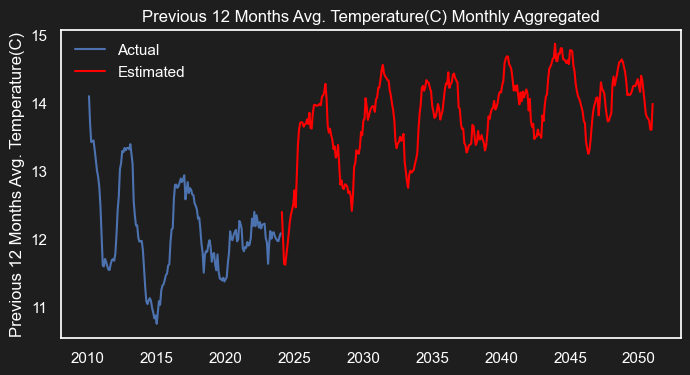

In [69]:
# Look at how avg. temp changes according to the NASA predictions

chart_df = combined_df.set_index("date")[["tmmn_prev12", "tmmx_prev12"]].resample("ME").mean()
chart_df["tmean_prev12"] = (chart_df["tmmn_prev12"] + chart_df["tmmx_prev12"]) / 2

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

sns.lineplot(data=chart_df["2010":"2023"], x = chart_df["2010":"2023"].index, y="tmean_prev12", label="Actual")
sns.lineplot(data=chart_df["2024":], x = chart_df["2024":].index, y="tmean_prev12", label="Estimated", color="red")

ax.set_xlabel('')
ax.set_ylabel('Previous 12 Months Avg. Temperature(C)')

ax.set_title('Previous 12 Months Avg. Temperature(C) Monthly Aggregated');

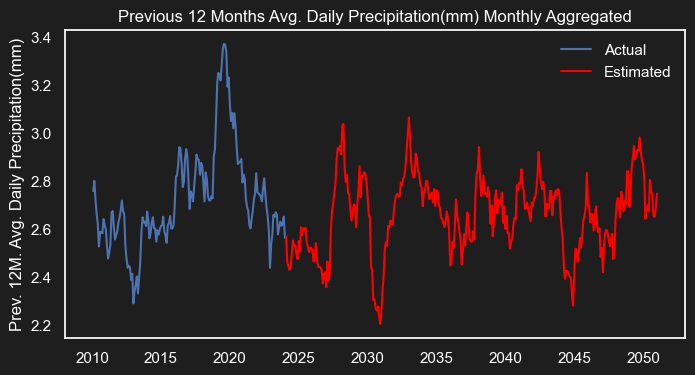

In [70]:
# Look at how avg. precipitation changes according to the NASA predictions

chart_df = combined_df.set_index("date")[["pr_prev12"]].resample("ME").mean()

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

sns.lineplot(data=chart_df["2010":"2023"], x = chart_df["2010":"2023"].index, y="pr_prev12", label="Actual")
sns.lineplot(data=chart_df["2024":], x = chart_df["2024":].index, y="pr_prev12", label="Estimated", color="red")

ax.set_xlabel('')
ax.set_ylabel('Prev. 12M. Avg. Daily Precipitation(mm)')

ax.set_title('Previous 12 Months Avg. Daily Precipitation(mm) Monthly Aggregated');

### PDSI Predictions till 2050

In [71]:
# take years with prediction climate data and remove non feature columns
# then appy transformation to X_predict

X_predict_24_50 = combined_df.query("year > 2023").drop(
    columns = ['id', 'region', 'date', 'pr', 'tmmn', 'tmmx', 'rmin', 'rmax', 'year', 'month']
)

for feat in X_predict_24_50.columns:
    if feat in right_skew:
        X_predict_24_50[feat] = np.sqrt(X_predict_24_50[feat])
    elif feat in left_skew:
        max_inst = X_predict_24_50[feat].max()
        X_predict_24_50[feat] = max_inst + 1 - X_predict_24_50[feat]
        X_predict_24_50[feat] = np.log(X_predict_24_50[feat])

In [72]:
# 355 regions x 27 years x 12 months =  115,020 

len(X_predict_24_50)

115020

In [73]:
# Check if the X model trained on has the columns as the new X

X_22_23.columns.equals(X_predict_24_50.columns)

True

In [74]:
predicted_till_2050 = rbf_svm.predict(X_predict_24_50)
X_predict_24_50["pdsi"] = predicted_till_2050

In [75]:
X_predict_24_50['id'] = X_predict_24_50.index.str.split('_').str[0]
X_predict_24_50['year'] = X_predict_24_50.index.str.split('_').str[1]
X_predict_24_50['month'] = X_predict_24_50.index.str.split('_').str[2]
X_predict_24_50['id'] = X_predict_24_50['id'].astype("int16")
X_predict_24_50['year'] = X_predict_24_50['year'].astype("int16")
X_predict_24_50['month'] = X_predict_24_50['month'].astype("int16")

In [76]:
# Add predictions to the features DF

X_predict_24_50["pdsi"] = predicted_till_2050

# Calculate min and max pdsi to macth scales of the following charts

min_pdsi = X_predict_24_50["pdsi"].min()
max_pdsi = X_predict_24_50["pdsi"].max()
min_pdsi //= 1
max_pdsi += 1
max_pdsi //= 1
print(min_pdsi, max_pdsi)

-5.0 6.0


In [77]:
X_predict_24_50['id'] = X_predict_24_50.index.str.split('_').str[0]
X_predict_24_50['year'] = X_predict_24_50.index.str.split('_').str[1]
X_predict_24_50['month'] = X_predict_24_50.index.str.split('_').str[2]
X_predict_24_50['id'] = X_predict_24_50['id'].astype("int16")
X_predict_24_50['year'] = X_predict_24_50['year'].astype("int16")
X_predict_24_50['month'] = X_predict_24_50['month'].astype("int16")

In [78]:
for year in range (2024,2051):

    chart_df = X_predict_24_50.query("year == @year").loc[:,["id","year","pdsi"]]
    chart_df = chart_df.groupby(["year","id"]).agg("mean").reset_index()
    
    c_map(
        df = chart_df, var="pdsi", scale_min=min_pdsi , scale_max=max_pdsi,
        chart_title=f"{year} Average PDSI Predictions" , save_title=f"{year}_Prediction.html"
    )